In [22]:
import copy
import os
import random
import shutil
import zipfile
from math import atan2, cos, sin, sqrt, pi, log

import torch
import torch.nn as nn
from torchvision import models
from torch.nn.functional import relu
import torchvision.transforms.functional as TF
import os
from PIL import Image
from torch.utils.data import Dataset
import numpy as np
from tqdm import tqdm
from torch import optim, nn
from torch.utils.data import DataLoader, random_split
from torch.utils.data.dataset import Dataset
from torchvision import transforms
from tqdm import tqdm
import copy
import os
import random
import shutil
import zipfile
from math import atan2, cos, sin, sqrt, pi, log

import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from PIL import Image
from numpy import linalg as LA
from torch import optim, nn
from torch.utils.data import DataLoader, random_split
from torch.utils.data.dataset import Dataset
from torchvision import transforms
from tqdm import tqdm

In [23]:
print(os.listdir("../input/dlp-object-detection/final_dlp_data/final_dlp_data/train"))

['labels', 'images']


In [24]:
transform = transforms.Compose([
            transforms.Resize((512,512)),
            transforms.ToTensor()
        ])
a = Image.open('/kaggle/input/dlp-object-detection/final_dlp_data/final_dlp_data/train/images/008b8a9c-dae2-4a58-accf-33165472de6e.jpeg').convert("RGB")
a = transform(a)
a.shape

torch.Size([3, 512, 512])

In [25]:
classes = {
"aegypti": 0,
"albopictus": 1,
"anopheles": 2,
"culex": 3,
"culiseta": 4,
"japonicus": 5,
"koreicus": 5
}

def get_mod_label(label):
    one_hot_enc = np.zeros(6)
    remaining = label[1:]
    one_hot_enc[int(label[0])-1] = 1
    return np.concatenate((one_hot_enc, remaining), axis=0)

    
class MosquitoDataset(Dataset):
    def __init__(self, image_dir, label_dir):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.transform = transforms.Compose([
            transforms.Resize((512,512)),
            transforms.ToTensor()
        ])
        self.images = os.listdir(image_dir)
    def __len__(self):
        return len(self.images)
    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.images[idx])
        label_path = os.path.join(self.label_dir, self.images[idx].replace(".jpeg", ".txt"))
        with open(label_path, 'r') as file:
            label = [line.strip().split(" ") for line in file]
            label = [float(x) for x in label[0]]
        image = Image.open(img_path).convert("RGB")
        
        return self.transform(image), get_mod_label(label).reshape(1, 1, 10)
            

In [26]:
classes

{'aegypti': 0,
 'albopictus': 1,
 'anopheles': 2,
 'culex': 3,
 'culiseta': 4,
 'japonicus': 5,
 'koreicus': 5}

In [27]:
DATASET_DIR = '../input/dlp-object-detection/final_dlp_data/final_dlp_data/train/'


In [28]:
train_dataset = MosquitoDataset(DATASET_DIR+'images', DATASET_DIR+'labels')

In [29]:
train_dataset, test_dataset = random_split(train_dataset, [0.8, 0.2])

(tensor([[[0.8627, 0.8627, 0.8588,  ..., 0.8706, 0.8706, 0.8745],
         [0.8588, 0.8510, 0.8510,  ..., 0.8784, 0.8784, 0.8784],
         [0.8549, 0.8471, 0.8431,  ..., 0.8824, 0.8784, 0.8745],
         ...,
         [0.7961, 0.7882, 0.8000,  ..., 0.8588, 0.8510, 0.8314],
         [0.8000, 0.7961, 0.8000,  ..., 0.8000, 0.8078, 0.8039],
         [0.8000, 0.8039, 0.8000,  ..., 0.7686, 0.7843, 0.7961]],

        [[0.8471, 0.8471, 0.8431,  ..., 0.8510, 0.8510, 0.8549],
         [0.8431, 0.8353, 0.8353,  ..., 0.8588, 0.8588, 0.8588],
         [0.8392, 0.8314, 0.8275,  ..., 0.8627, 0.8588, 0.8549],
         ...,
         [0.7569, 0.7490, 0.7608,  ..., 0.8235, 0.8157, 0.7961],
         [0.7608, 0.7569, 0.7608,  ..., 0.7647, 0.7725, 0.7686],
         [0.7608, 0.7647, 0.7608,  ..., 0.7333, 0.7490, 0.7608]],

        [[0.8118, 0.8118, 0.8078,  ..., 0.8275, 0.8275, 0.8314],
         [0.8078, 0.8000, 0.8000,  ..., 0.8353, 0.8353, 0.8353],
         [0.8039, 0.7961, 0.7922,  ..., 0.8392, 0.8353, 0

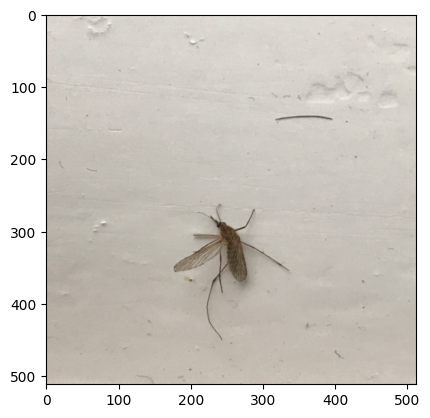

In [30]:
img = train_dataset[0]
print(img)
imgPIL = img[0].permute(1,2,0)
imgPIL.size()
plt.imshow(imgPIL.numpy())


In [31]:
img[1]

array([[[0.        , 0.        , 1.        , 0.        , 0.        ,
         0.        , 0.49479167, 0.6875    , 0.30989583, 0.36132812]]])

In [32]:
os.cpu_count()

4

In [33]:
device = "cuda" if torch.cuda.is_available() else "cpu"

if device == "cuda":
    NUM_WORKERS = torch.cuda.device_count() * min(4, os.cpu_count())
else: 
    NUM_WORKERS = min(4, os.cpu_count())

In [34]:
LEARNING_RATE = 3e-4
BATCH_SIZE = 8
PIN_MEMORY = False
SHUFFLE = True

In [35]:
from functools import partial

setup_dataloader = partial(DataLoader, 
                           num_workers=NUM_WORKERS,
                           pin_memory=PIN_MEMORY,
                           batch_size=BATCH_SIZE,
                           shuffle=SHUFFLE
                          )

In [36]:
class ConvBlock(nn.Module):
    def __init__(self, in_channel, out_channel, filter_size):
        super(ConvBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channel, out_channel, filter_size, 1, 1, bias=False),
            nn.BatchNorm2d(out_channel),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
    def forward(self, x):
        return self.block(x)
        
class YOLO(nn.Module):
    def __init__(self, in_channel, out_channel):
        super(YOLO, self).__init__()
        self.net = nn.Sequential(
            ConvBlock(in_channel, 4, 3),
            ConvBlock(4, 8, 3),
            ConvBlock(8, 16, 5),
            ConvBlock(16, 8, 10),
            ConvBlock(8, 1, 10),
            nn.Conv2d(1, 1, kernel_size=(10, 1), stride=1)
        )
    def forward(self, x):
        return self.net(x)
        

In [47]:
model = YOLO(3, 1).to(device)
model

YOLO(
  (net): Sequential(
    (0): ConvBlock(
      (block): Sequential(
        (0): Conv2d(3, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
    )
    (1): ConvBlock(
      (block): Sequential(
        (0): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
    )
    (2): ConvBlock(
      (block): Sequential(
        (0): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(i

In [48]:
def test():
    inp = torch.randn((10, 3, 512, 512))
    model = YOLO(3, 1)
    out = model(inp)
    print(inp.shape)
    print(out.shape)

test()

torch.Size([10, 3, 512, 512])
torch.Size([10, 1, 1, 10])


In [49]:
import torch.nn.functional as F

class YoloCombinedLoss(nn.Module):
    def __init__(self, bce_weight=1.0, mse_weight=1.0):
        super(YoloCombinedLoss, self).__init__()
        self.bce_loss = nn.BCEWithLogitsLoss() # Use BCEWithLogitsLoss for numerical stability
        self.mse_loss = nn.MSELoss()
        self.bce_weight = bce_weight
        self.mse_weight = mse_weight

    def forward(self, output, target):
        # Squeeze dimensions to (m, 10) for easier indexing if necessary,
        # but BCEWithLogitsLoss and MSELoss can handle the 1,1,1 dimensions if consistent.
        # Let's assume output and target are already (m, 10) after potential squeezing
        # or we handle the slicing with the extra dimensions.
        
        # Original shape: (m, 1, 1, 10)
        # We need to reshape to (m, 10) for easier slicing.
        # .squeeze(-2).squeeze(-2) removes the dimensions of size 1 at index -2 and -3.
        # Or, you can explicitly reshape: .view(output.shape[0], -1)
        # print(f"""
        # !!!!!!!!!!!!!!!!!
        # {output.shape}
        # {target.shape}
        # !!!!!!!!!!!!!!!!
        # """)
        output_flat = output.squeeze(-2).squeeze(-2) # Becomes (m, 10)
        target_flat = target.squeeze(-2).squeeze(-2) # Becomes (m, 10)
        
        # Extract the first 6 elements for BCE
        output_bce = output_flat[:, :6]
        target_bce = target_flat[:, :6]

        # Extract the last 4 elements for MSE
        output_mse = output_flat[:, 6:]
        target_mse = target_flat[:, 6:]

        # Calculate BCE Loss
        # BCEWithLogitsLoss expects 'logits' (raw output before sigmoid) for output.
        # Target should be floats (0.0 or 1.0).
        bce_part = self.bce_loss(output_bce, target_bce)

        # Calculate MSE Loss
        mse_part = self.mse_loss(output_mse, target_mse)

        # Combine the losses with weights
        total_loss = (self.bce_weight * bce_part) + (self.mse_weight * mse_part)

        return total_loss

In [50]:
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)
criterion = YoloCombinedLoss()
torch.cuda.empty_cache()

train_dataloader = setup_dataloader(dataset=train_dataset)
test_dataloader = setup_dataloader(dataset=test_dataset)

In [51]:
def train_yolo(epochs):
    EPOCHS = epochs

    train_losses = []
    val_losses = []
    
    for epoch in tqdm(range(EPOCHS)):
        model.train()
        train_running_loss = 0
        
        for idx, img_label in enumerate(tqdm(train_dataloader, position=0, leave=True)):
            img = img_label[0].float().to(device)
            label = img_label[1].float().to(device)
            
            y_pred = model(img)
            optimizer.zero_grad()            
            loss = criterion(y_pred, label)
            
            train_running_loss += loss.item()
    
            loss.backward()
            optimizer.step()
    
        train_loss = train_running_loss / (idx + 1)
        
        train_losses.append(train_loss)
    
        model.eval()
        val_running_loss = 0
        
        with torch.no_grad():
            for idx, img_label in enumerate(tqdm(test_dataloader, position=0, leave=True)):
                img = img_label[0].float().to(device)
                label = img_label[1].float().to(device)
    
                y_pred = model(img)
                loss = criterion(y_pred, label)
                
                val_running_loss += loss.item()
    
            val_loss = val_running_loss / (idx + 1)
        
        val_losses.append(val_loss)
    
        print("-" * 30)
        print(f"Training Loss EPOCH {epoch + 1}: {train_loss:.4f}")
        print("\n")
        print(f"Validation Loss EPOCH {epoch + 1}: {val_loss:.4f}")
        print("-" * 30)
    
    # Saving the model
    torch.save(model.state_dict(), 'my_checkpoint.pth')
    return train_losses, val_losses

In [52]:
EPOCHS = 10
train_losses, val_losses = train_yolo(EPOCHS)

  5%|▌         | 38/750 [00:14<03:45,  3.16it/s] /usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
 17%|█▋        | 130/750 [00:43<01:41,  6.09it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
 10%|█         | 1/10 [05:03<45:29, 303.24s/it]

------------------------------
Training Loss EPOCH 1: 0.9666


Validation Loss EPOCH 1: 0.8173
------------------------------


 16%|█▌        | 121/750 [00:40<02:13,  4.72it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
 96%|█████████▋| 722/750 [03:43<00:04,  6.21it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
 20%|██        | 2/10 [09:59<39:55, 299.42s/it]

------------------------------
Training Loss EPOCH 2: 0.7817


Validation Loss EPOCH 2: 0.7593
------------------------------


 60%|█████▉    | 449/750 [02:31<01:26,  3.48it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
 89%|████████▉ | 669/750 [03:33<00:15,  5.36it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
 30%|███       | 3/10 [14:58<34:52, 298.94s/it]

------------------------------
Training Loss EPOCH 3: 0.7439


Validation Loss EPOCH 3: 0.7410
------------------------------


 20%|██        | 152/750 [00:52<02:19,  4.30it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
 45%|████▍     | 336/750 [01:56<02:04,  3.33it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
 40%|████      | 4/10 [20:01<30:02, 300.42s/it]

------------------------------
Training Loss EPOCH 4: 0.7202


Validation Loss EPOCH 4: 0.7285
------------------------------


  7%|▋         | 53/750 [00:19<02:30,  4.63it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
 40%|███▉      | 297/750 [01:37<01:15,  6.04it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
 50%|█████     | 5/10 [25:01<25:02, 300.55s/it]

------------------------------
Training Loss EPOCH 5: 0.7106


Validation Loss EPOCH 5: 0.7155
------------------------------


 85%|████████▍ | 636/750 [03:25<00:37,  3.05it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
 89%|████████▊ | 664/750 [03:36<00:18,  4.55it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
 60%|██████    | 6/10 [30:07<20:08, 302.13s/it]

------------------------------
Training Loss EPOCH 6: 0.7032


Validation Loss EPOCH 6: 0.7132
------------------------------


 22%|██▏       | 163/750 [00:55<02:16,  4.30it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
 43%|████▎     | 322/750 [01:50<02:10,  3.27it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
 70%|███████   | 7/10 [35:08<15:06, 302.01s/it]

------------------------------
Training Loss EPOCH 7: 0.6984


Validation Loss EPOCH 7: 0.7116
------------------------------


  6%|▌         | 42/750 [00:16<05:47,  2.04it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
 88%|████████▊ | 662/750 [03:36<00:44,  1.98it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
 80%|████████  | 8/10 [40:13<10:05, 302.77s/it]

------------------------------
Training Loss EPOCH 8: 0.6946


Validation Loss EPOCH 8: 0.7130
------------------------------


 11%|█         | 84/750 [00:31<03:04,  3.61it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
 43%|████▎     | 320/750 [01:48<01:26,  4.98it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
 90%|█████████ | 9/10 [45:16<05:03, 303.05s/it]

------------------------------
Training Loss EPOCH 9: 0.6907


Validation Loss EPOCH 9: 0.7080
------------------------------


 27%|██▋       | 202/750 [01:09<02:57,  3.08it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
 73%|███████▎  | 549/750 [02:58<00:31,  6.29it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
100%|██████████| 10/10 [50:18<00:00, 301.81s/it]

------------------------------
Training Loss EPOCH 10: 0.6891


Validation Loss EPOCH 10: 0.7066
------------------------------
